# Pipeline: Regression Models

## 1. Introduction

Twelve years' worth of Reliance India Adjusted Close price data will be used to see if it possible to forecast out 'n' days in the future. Fourteen models will be compared to see whether Gradient-Descent Based, Distance-Based or Tree-Based algorithms perform best.

After a spot check of the models the best performing will be selected and Grid Search cross validation will then be used to find the best parameters for tuning the models, and visualising the results.




## 2. Install/import libraries

In [68]:
!pip install yfinance as yfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [70]:
RI_df = yf.download("RELIANCE.NS", start="2011-04-01", end="2023-03-31")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


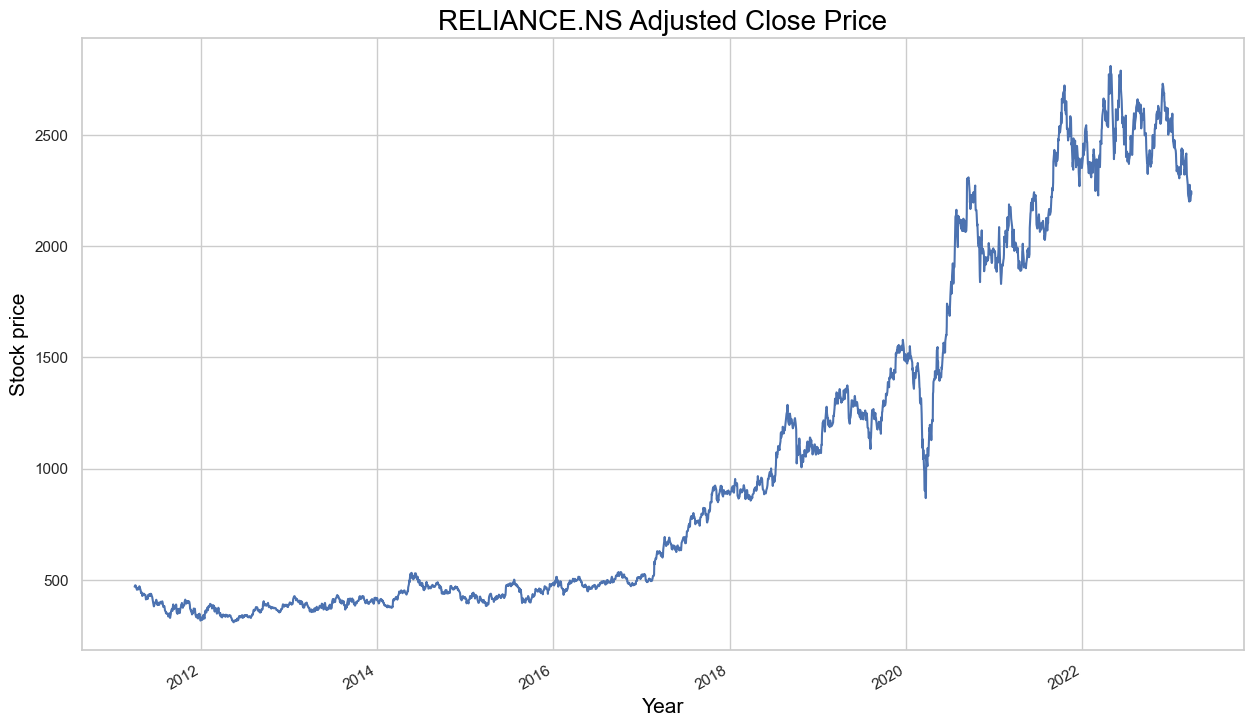

In [71]:
# Plot Adjusted Close price

RI_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('RELIANCE.NS Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [72]:
# Create Dataframe for Adjusted Close prices

RI_adj = RI_df[['Adj Close']]
RI_adj 

,Adj Close
Date,
2011-04-01,468.43
2011-04-04,474.88
2011-04-05,473.52
2011-04-06,472.25
2011-04-07,470.92
...,...
2023-03-23,2247.80
2023-03-24,2203.30
2023-03-27,2237.55


## 4. Feature engineering
The Adjusted Close price will be shifted 'n' days in the future to create a column of prices for prediction.

In [73]:
# A variable for predicting 'n' days into the future

forecast_out = 30

# Create column for target variable shifted 'n' days up
RI_adj['Prediction'] = RI_adj[['Adj Close']].shift(-forecast_out)

RI_adj

,Adj Close,Prediction
Date,,
2011-04-01,468.43,411.09
2011-04-04,474.88,417.31
2011-04-05,473.52,420.82
2011-04-06,472.25,414.53
2011-04-07,470.92,417.43
...,...,...
2023-03-23,2247.80,NaN
2023-03-24,2203.30,NaN
2023-03-27,2237.55,NaN


## 5. Splitting the data

The last 'n' rows will be removed as these rows are NaNs in the Prediction column (y variable). 

In [74]:
X = np.array(RI_adj.iloc[:,:-1])
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[ 468.43]
 [ 474.88]
 [ 473.52]
 ...
 [2336.65]
 [2323.35]
 [2378.1 ]]


In [75]:
y = np.array(RI_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[ 411.09  417.31  420.82 ... 2237.55 2248.   2234.7 ]


The data will be split into training and test sets.

In [76]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [77]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2049, 1)
(2049,)
(879, 1)
(879,)


In [78]:
print(X_train)
print(y_train)

[[ 468.43]
 [ 474.88]
 [ 473.52]
 ...
 [1183.92]
 [1181.14]
 [1151.83]]
[ 411.09  417.31  420.82 ... 1187.1  1202.05 1187.49]


The last 'n' days of the Adjusted Close price will be saved as an array.

In [79]:
X_forecast = np.array(RI_adj.iloc[:,:-1])[-forecast_out:]
print(X_forecast)

[[2431.95]
 [2430.05]
 [2440.2 ]
 [2414.4 ]
 [2434.1 ]
 [2378.9 ]
 [2367.5 ]
 [2383.7 ]
 [2367.85]
 [2322.55]
 [2343.9 ]
 [2326.05]
 [2385.4 ]
 [2408.7 ]
 [2417.35]
 [2359.25]
 [2322.7 ]
 [2284.5 ]
 [2275.95]
 [2237.05]
 [2225.9 ]
 [2223.1 ]
 [2201.25]
 [2269.7 ]
 [2276.6 ]
 [2247.8 ]
 [2203.3 ]
 [2237.55]
 [2248.  ]
 [2234.7 ]]


## 6. Evaluate algorithms

A dictionary of models will be created to spot check using default parameters, and select the best performing ones for tuning.

In [80]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

###  Spot check algorithms



To avoid look-ahead bias we will use sklearn's TimeSeriesSplit class so that models are not trained on data they have already seen. 



In [81]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

Linear: -0.228392, (0.518371)
Lasso: -0.228857, (0.518514)
Ridge: -0.228393, (0.518372)
ElasticNet: -0.228768, (0.518436)
KNN: -1.251028, (1.11995)
DecisionTree: -2.198133, (2.499706)
SVR: -4.966081, (6.119049)
AdaBoost: -1.469518, (1.641881)
GradientBoost: -1.691208, (2.267886)
RandomForest: -1.620578, (1.749595)
ExtraTrees: -2.049317, (2.535206)
BaggingRegressor: -1.643884, (1.758982)
XGBRegressor: -1.982291, (2.439195)
MLPRegressor: -0.247093, (0.548384)


### Boxplot to compare regression models

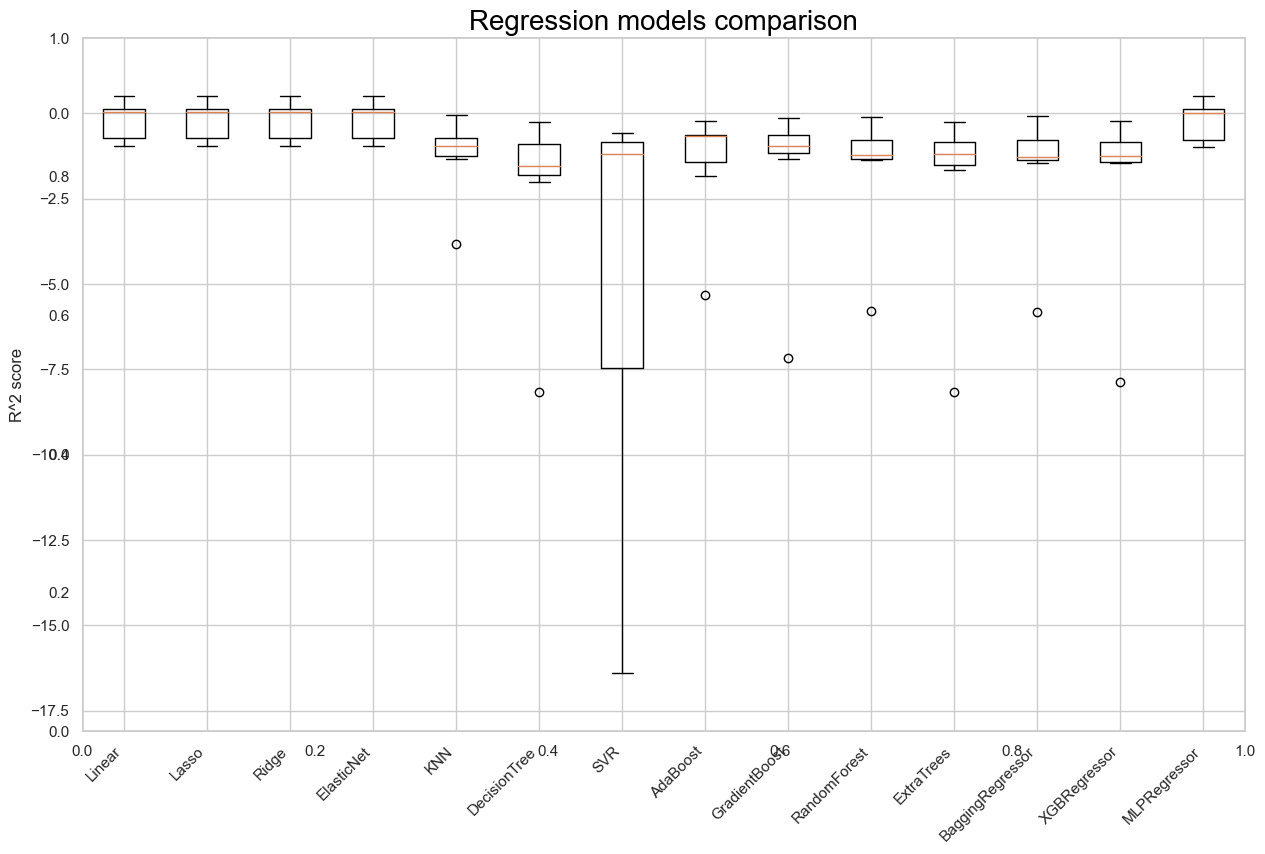

In [82]:
# Compare algorithms  

def box_compare():
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

The performance scores and box plots show that the linear models and the neural network perform the best. We will select Linear Regression and the MLP Regressor. Both are Gradient-Descent based models, although one is linear and the other non-linear.

## 7. Modelling

We will create, train, test and tune Linear Regression and MLP Regressor models.

### 7.1 Create, train and predict on Linear Regression model

We will look at the Linear Regression model first. It adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.









In [83]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [84]:
# Make predictions using the model
predictions = lr.predict(X_test)

### Print performance metrics
The performance metric R<sup>2</sup>, or the coefficient of determination, tells us how much variance in the target variable is explained by our model. Values can range from 0 to 1. In general higher values are better, indicating that a model is highly predictive.

In [85]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [1.01375047]
RMSE: 209.28
R^2 score: 0.775


The R<sup>2</sup> score tells us that 78% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

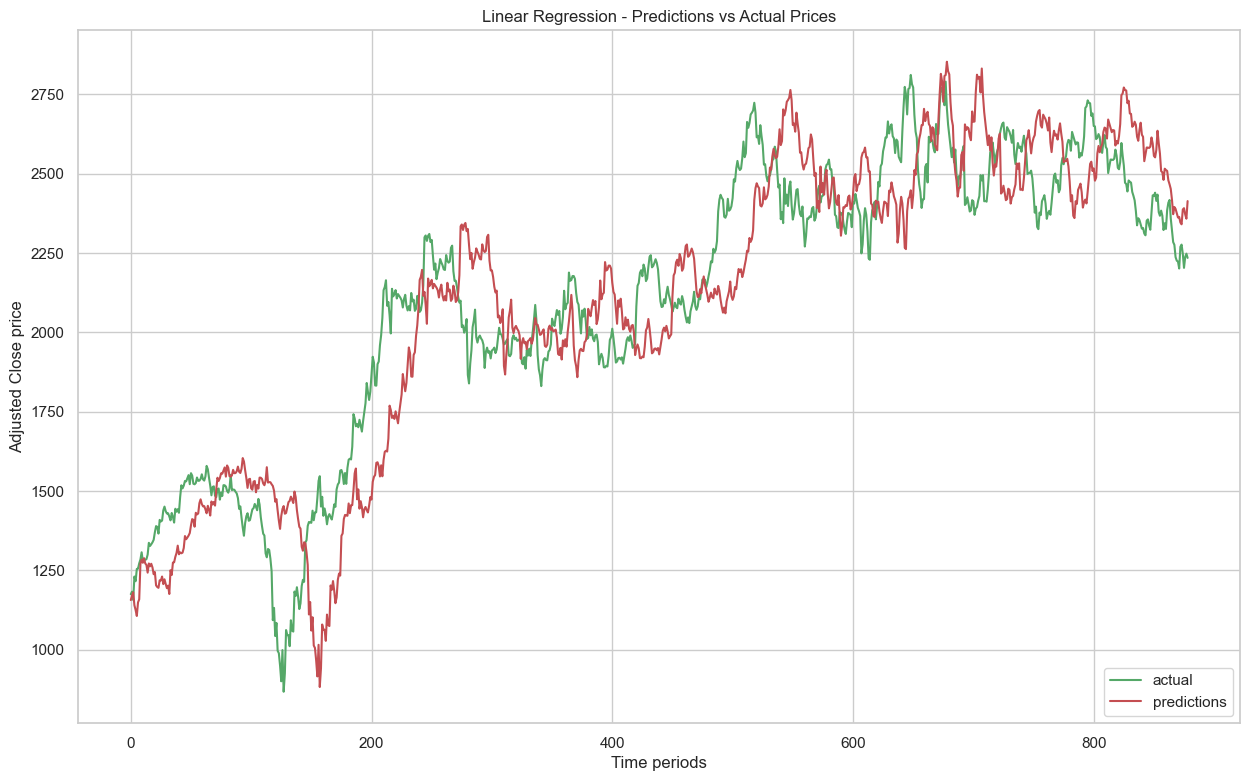

In [86]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [87]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,1174.44,1156.125616
1,1182.53,1169.973447
2,1156.40,1180.506315
3,1230.25,1139.743408
4,1215.39,1124.780451


### Scatterplot

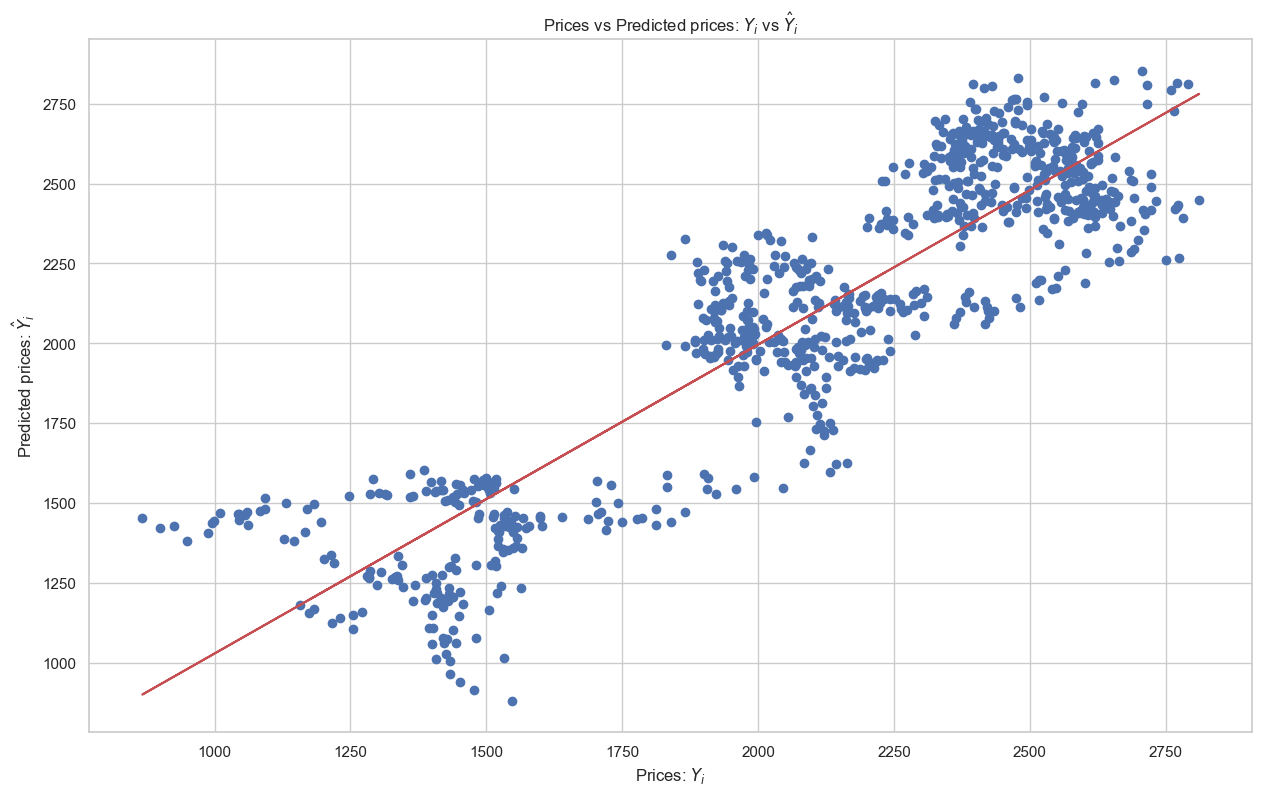

In [88]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [89]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[2468.33435867 2466.40823278 2476.69780002 2450.54303796 2470.51392217
 2414.55489636 2402.99814103 2419.4208986  2403.35295369 2357.43005751
 2379.07362999 2360.97818415 2421.1442744  2444.76466029 2453.53360184
 2394.63469967 2357.58212008 2318.85685222 2310.18928572 2270.75439253
 2259.45107481 2256.6125735  2234.46212579 2303.8533453  2310.84822352
 2281.65221005 2236.54031425 2271.26126776 2281.85496015 2268.37207893]


In [90]:
# Actual prices

X_forecast

array([[2431.95],
       [2430.05],
       [2440.2 ],
       [2414.4 ],
       [2434.1 ],
       [2378.9 ],
       [2367.5 ],
       [2383.7 ],
       [2367.85],
       [2322.55],
       [2343.9 ],
       [2326.05],
       [2385.4 ],
       [2408.7 ],
       [2417.35],
       [2359.25],
       [2322.7 ],
       [2284.5 ],
       [2275.95],
       [2237.05],
       [2225.9 ],
       [2223.1 ],
       [2201.25],
       [2269.7 ],
       [2276.6 ],
       [2247.8 ],
       [2203.3 ],
       [2237.55],
       [2248.  ],
       [2234.7 ]])

### Print performance metrics

In [91]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [1.01375047]
RMSE: 34.907
R^2 score: 0.799


The R<sup>2</sup> score tells us that 80% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices





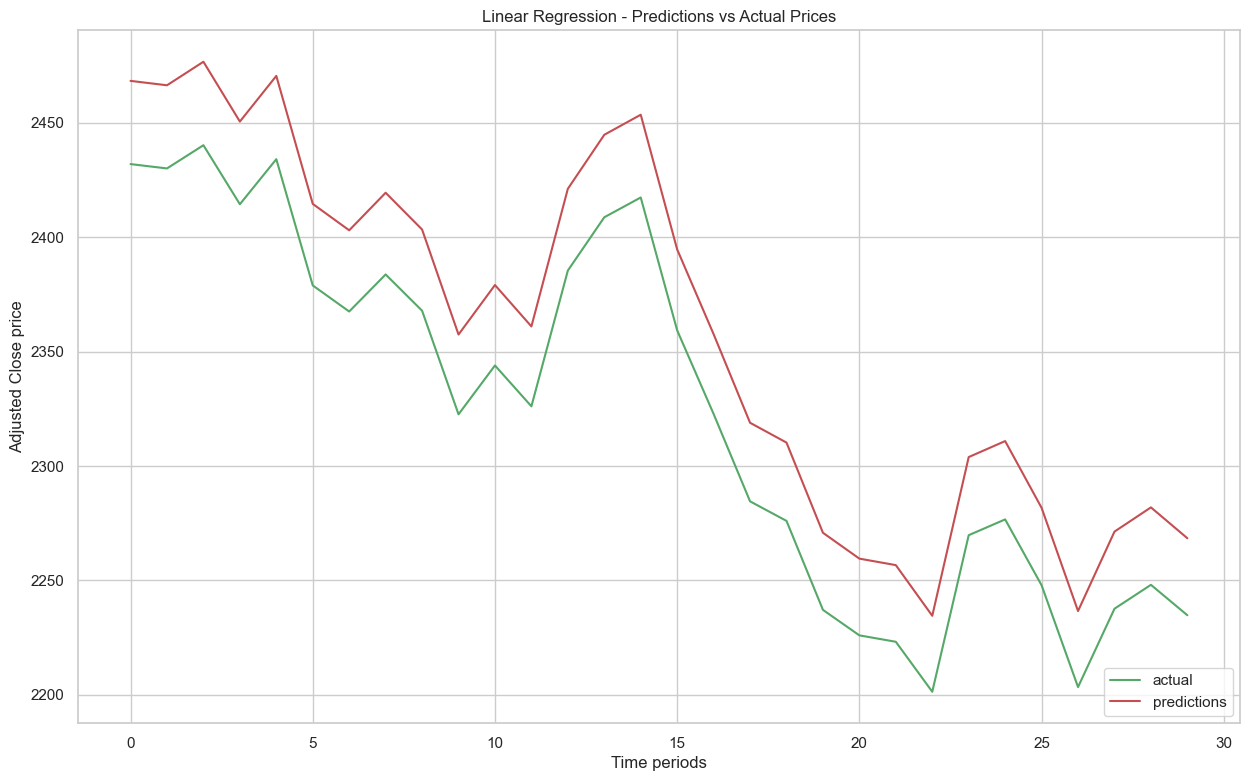

In [92]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [93]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast 

array([2431.95, 2430.05, 2440.2 , 2414.4 , 2434.1 , 2378.9 , 2367.5 ,
       2383.7 , 2367.85, 2322.55, 2343.9 , 2326.05, 2385.4 , 2408.7 ,
       2417.35, 2359.25, 2322.7 , 2284.5 , 2275.95, 2237.05, 2225.9 ,
       2223.1 , 2201.25, 2269.7 , 2276.6 , 2247.8 , 2203.3 , 2237.55,
       2248.  , 2234.7 ])

In [94]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()

,Actual,Predict
0,2431.95,2468.334359
1,2430.05,2466.408233
2,2440.20,2476.697800
3,2414.40,2450.543038
4,2434.10,2470.513922


### Grid Search to find optimum parameters

In [95]:
# Create dictionary of parameters
parameters = {'copy_X': [True, False], 'fit_intercept': [True, False],
         'n_jobs': [None, -1]}

In [96]:
# Grid search to find best parameters
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: -0.2051718429310308 using {'copy_X': True, 'fit_intercept': False, 'n_jobs': None}


In [97]:
# All of the best parameters for the optimal model

best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best model has the following hyperparameters: LinearRegression(fit_intercept=False)


### Create, train and test tuned model

In [98]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[2431.95],
       [2430.05],
       [2440.2 ],
       [2414.4 ],
       [2434.1 ],
       [2378.9 ],
       [2367.5 ],
       [2383.7 ],
       [2367.85],
       [2322.55],
       [2343.9 ],
       [2326.05],
       [2385.4 ],
       [2408.7 ],
       [2417.35],
       [2359.25],
       [2322.7 ],
       [2284.5 ],
       [2275.95],
       [2237.05],
       [2225.9 ],
       [2223.1 ],
       [2201.25],
       [2269.7 ],
       [2276.6 ],
       [2247.8 ],
       [2203.3 ],
       [2237.55],
       [2248.  ],
       [2234.7 ]])

In [99]:
# Create Linear Regression model
lr = LinearRegression(copy_X=False, fit_intercept=False, n_jobs=None, positive=True)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

Coefficients:  [1.01784337]
RMSE: 41.479
R^2 score: 0.716


The R<sup>2</sup> score has increased from 80% to 71%.

### Visualise predicted vs actual prices of tuned model

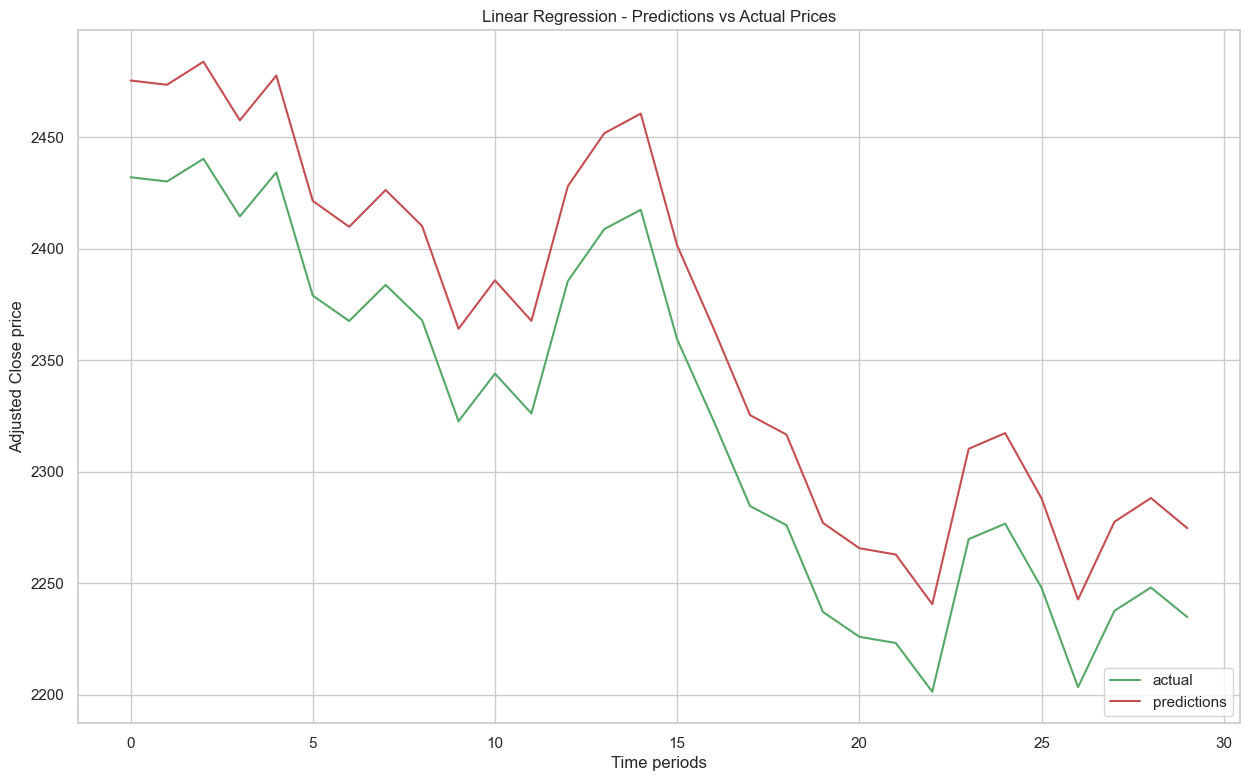

In [100]:
# Plot predictions against actual Adjusted Close prices  

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

We can see that there is now a much better fit.

### 7.2 Create and train MLP Regressor model

The Multi-Layer Perceptron (MLP) Regressor model from scikit-learn is a class of feedforward neural network. We will create and train the model for 500 iterations using the 'lbfgs' solver which is more suited to smaller data sets and can converge faster and perform better than stochastic solvers like 'sgd' and 'adam' which work well on relatively large datasets (with thousands of training samples or more).

In [101]:
# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [102]:
# Make predictions using the model
predictions = mlpr.predict(X_test)

### Print performance metrics

In [103]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 209.28
R^2 score: 0.775


The R<sup>2</sup> score tells us that 78% of the variation in y can be explained by the dependence on X.

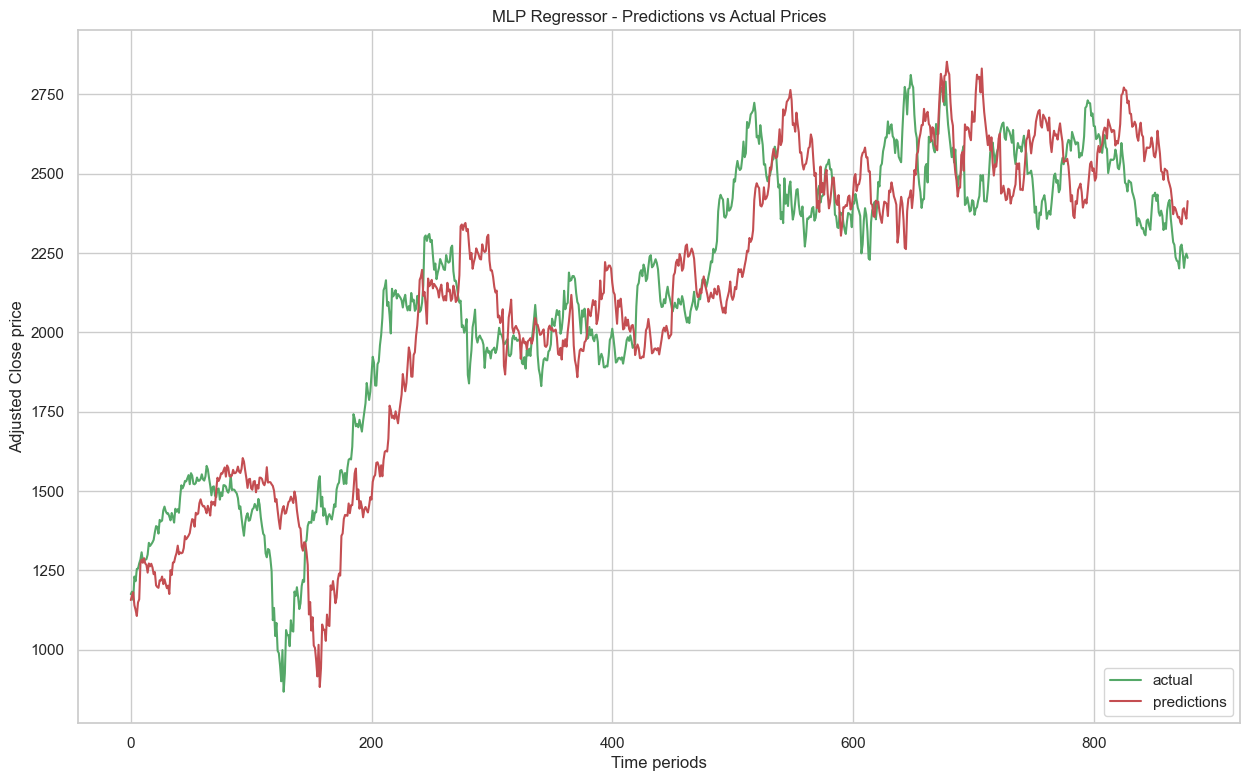

In [104]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [105]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,1174.44,1156.125376
1,1182.53,1169.973203
2,1156.40,1180.506066
3,1230.25,1139.743175
4,1215.39,1124.780224


### Scatterplot

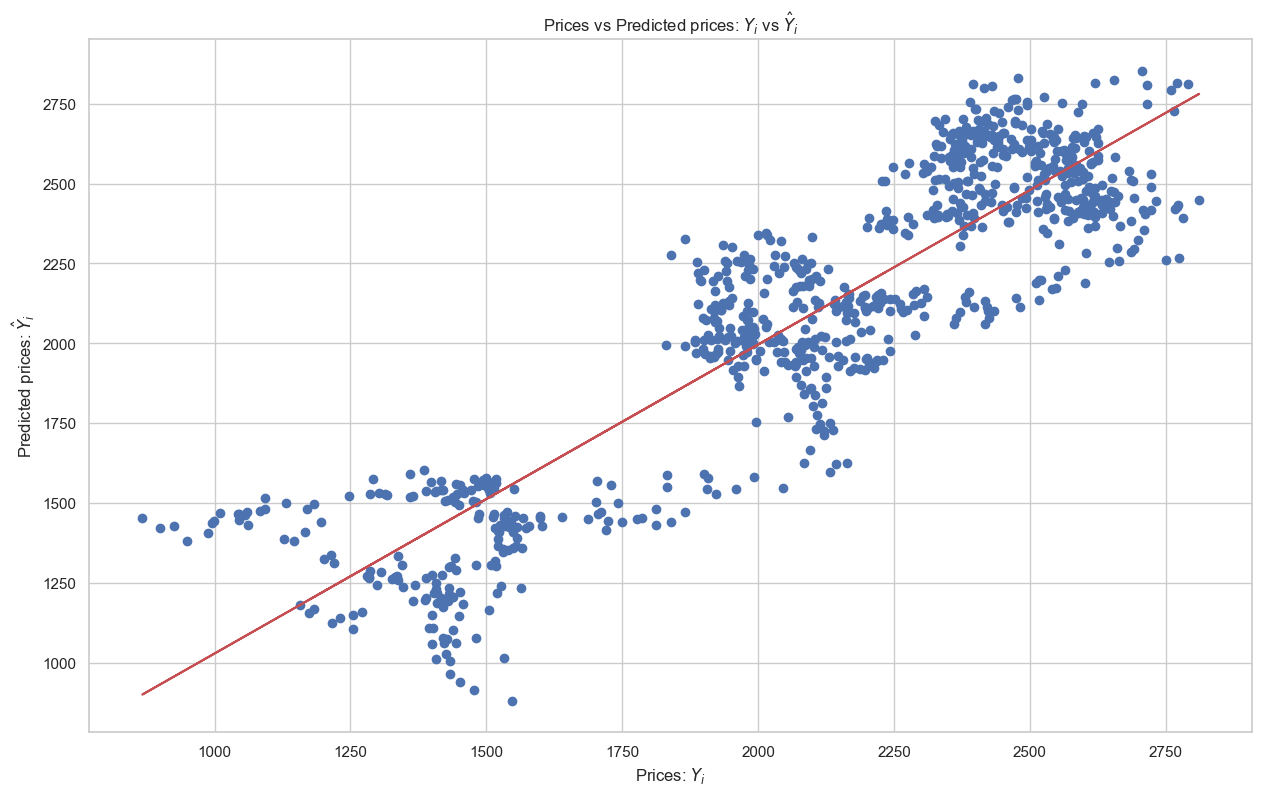

In [106]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [107]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[2468.3336308  2466.40750563 2476.69706905 2450.54231672 2470.5131935
 2414.55418851 2402.99743749 2419.42018895 2403.35225002 2357.42937093
 2379.07293535 2360.97749624 2421.1435641  2444.76394121 2453.53287949
 2394.63399924 2357.58143344 2318.85617999 2310.18861672 2270.75373821
 2259.4504247  2256.61192445 2234.46148497 2303.85267865 2310.84755428
 2281.65155168 2236.53967266 2271.26061325 2281.85430169 2268.37142549]


In [108]:
print(X_forecast)

[[2431.95]
 [2430.05]
 [2440.2 ]
 [2414.4 ]
 [2434.1 ]
 [2378.9 ]
 [2367.5 ]
 [2383.7 ]
 [2367.85]
 [2322.55]
 [2343.9 ]
 [2326.05]
 [2385.4 ]
 [2408.7 ]
 [2417.35]
 [2359.25]
 [2322.7 ]
 [2284.5 ]
 [2275.95]
 [2237.05]
 [2225.9 ]
 [2223.1 ]
 [2201.25]
 [2269.7 ]
 [2276.6 ]
 [2247.8 ]
 [2203.3 ]
 [2237.55]
 [2248.  ]
 [2234.7 ]]


### Print performance metrics

In [109]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 34.907
R^2 score: 0.799


The R<sup>2</sup> score tells us that 80% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

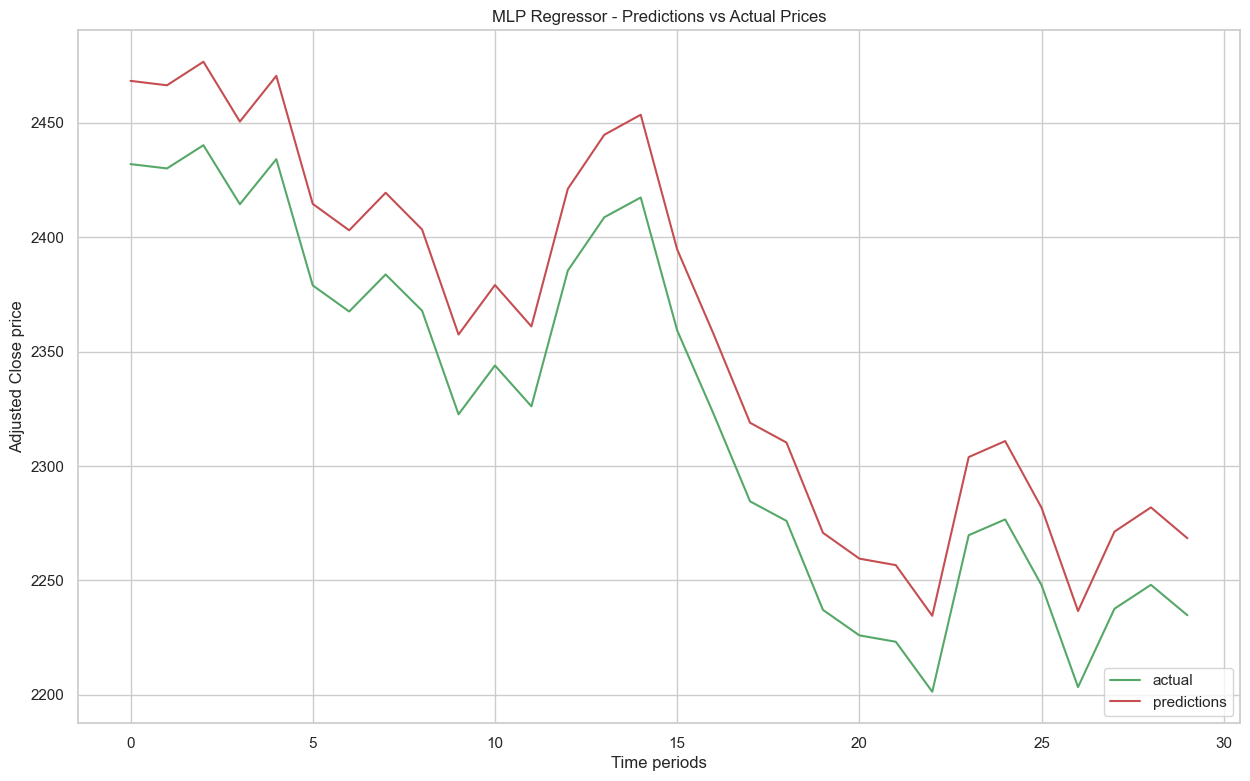

In [110]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

#### Create DataFrame of actual vs predicted prices

In [111]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [112]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,2431.95,2468.333631
1,2430.05,2466.407506
2,2440.20,2476.697069
3,2414.40,2450.542317
4,2434.10,2470.513193


### Feature scaling
Multi-layer Perceptron is sensitive to feature scaling. We will normalise the training data before model fitting by converting values to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance. This is useful for optimisation algorithms and used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs, like regression and neural networks.

In [113]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [114]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

### Grid Search to find optimum parameters

In [115]:
# Create model

mlpr = MLPRegressor(max_iter=500)

In [116]:
# Create dictionary of parameters to iterate over

parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.0001, 0.05], 
              "learning_rate": ['constant','adaptive']}

In [117]:
# Grid search to find best parameters

gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

Best: -0.13748620769679434 using {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [118]:
# All of the best parameters for the optimal model  

best_model_mlpr = grid_result_mlpr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_mlpr}")

Best model has the following hyperparameters: MLPRegressor(alpha=0.05, learning_rate='adaptive', max_iter=500, solver='lbfgs')


### Create, train and test tuned model

In [119]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[2431.95],
       [2430.05],
       [2440.2 ],
       [2414.4 ],
       [2434.1 ],
       [2378.9 ],
       [2367.5 ],
       [2383.7 ],
       [2367.85],
       [2322.55],
       [2343.9 ],
       [2326.05],
       [2385.4 ],
       [2408.7 ],
       [2417.35],
       [2359.25],
       [2322.7 ],
       [2284.5 ],
       [2275.95],
       [2237.05],
       [2225.9 ],
       [2223.1 ],
       [2201.25],
       [2269.7 ],
       [2276.6 ],
       [2247.8 ],
       [2203.3 ],
       [2237.55],
       [2248.  ],
       [2234.7 ]])

In [120]:
# Create MLP Regression model  
mlpr = MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

RMSE: 40.58
R^2 score: 0.728


The R<sup>2</sup> score has decreased from 80% to 73%.

### Visualise predicted vs actual prices of tuned model

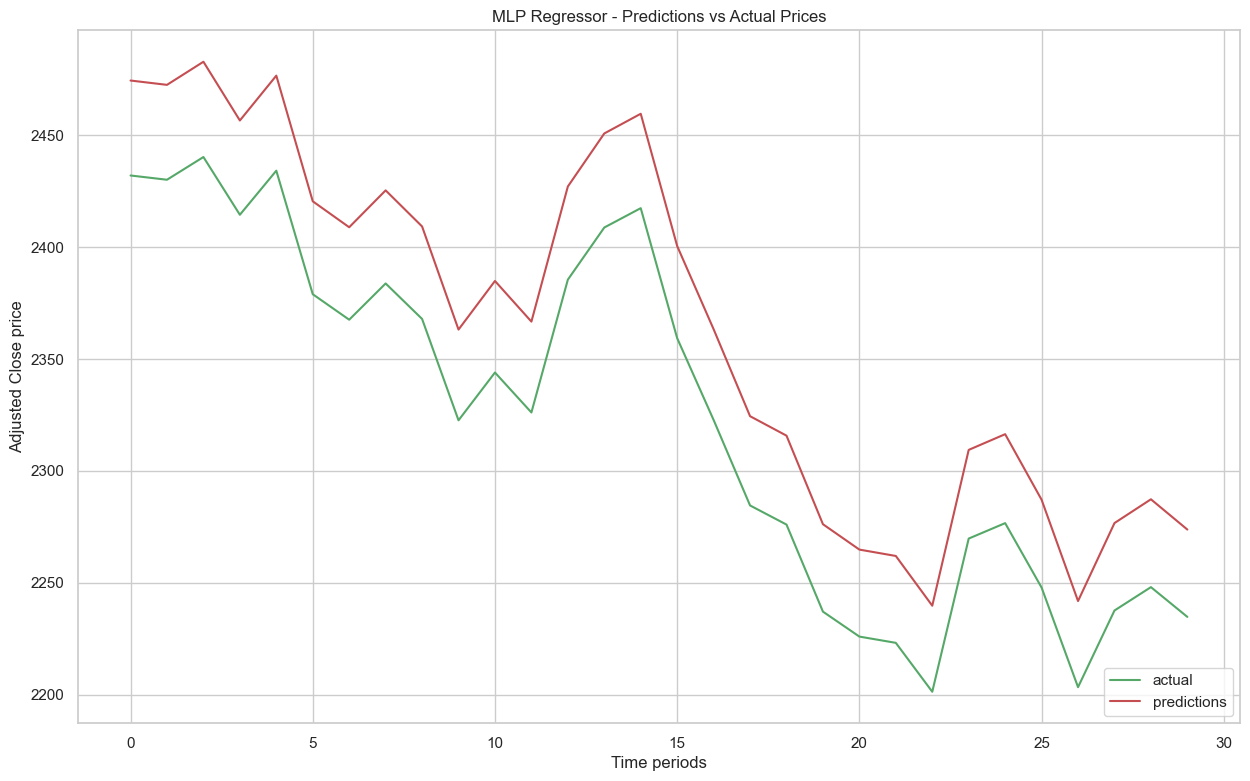

In [121]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()